## ClimaLSM Compatible DALEC Model

**By Jianing Fang (jf3423@columbia.edu), last revision August 2022**

In [1]:
using OrdinaryDiffEq: solve, DiscreteProblem, FunctionMap
using ClimaLSM: make_ode_function, initialize, prognostic_vars
using DALEC
using Plots
Plots.pyplot();

To run the model we would need both meterological drivers (CBF) and model parameters. An example CBF driver (in NetCDF format) is provided for the AU-How FLUXNET site between 2001-2014. The calibrated parameters for this site are also provided for demonstrative purposes. Currently we implemented the DALEC811 model version in this repository.

In [2]:
DRIVER_PATH = "../data/AU-How_example_driver.nc.cbf";
PARAM_PATH = "../data/AU-How_example_param.csv";
FT = Float64;

In [3]:
# load the meterological drivers and the model params
dalec = load_dalec_811(DRIVER_PATH, PARAM_PATH, FT);

In [4]:
# create the ode function. DALEC is a discrete model that needs to be casted in as a DiscreteProblem
# and integrated at weekly or monthly time step using the FunctionalMap solver.
ode_function! = make_ode_function(dalec);

In [5]:
Y, p, _ = initialize(dalec)

# set up the initial conditions with an in-place function, 
# which corresponds to the initial water and carbon pools.
load_initial_condition!(dalec, Y);

# Now solve the model
trange=(0,dalec.NODAYS)
prob = DiscreteProblem(ode_function!, Y, trange, p)
sol=Array(solve(prob, FunctionMap{true}()))

39×169 Matrix{Float64}:
     0.0            2.86206     …      1.54952          2.1745
     0.0            6.93571            4.35925          5.90044
     0.0            2.30134            4.03244          4.00934
     0.0            0.95512            1.15149          1.16402
     0.0            1.46512            0.920863         1.24643
     0.0            0.0574538   …      0.036111         0.0488779
     0.0            1.15088            0.723356         0.979096
     0.0            0.194172           0.122042         0.165189
     0.0            4.06807            2.55688          3.46085
     0.0            0.0202128          0.0102107        0.0150604
     0.0            0.00117966  …      0.000696291      0.00108749
     0.0            1.88069            1.22559          1.88725
     0.0            1.59719            0.500281         0.96884
     ⋮                          ⋱                   
     0.0            0.0                0.0              0.0
     0.0            0.0

Solving the model results in a n_vars x (n_months+1) matrix. The first column corresponds to the initial conditions, each subsequent column contains the solution of prognostic variable vector in each following month. We can find out what these variables represent with `prognostic_vars(dalec)`. To visulize the results, let's plot a few fluxes from the model output.

In [6]:
dalec_vars = prognostic_vars(dalec)

(:LAI, :GPP, :ET, :temperate, :respiration_auto, :leaf_production, :labile_production, :root_production, :wood_production, :lff, :lrf, :labile_release, :leaf_litter, :wood_litter, :root_litter, :respiration_hetero_litter, :respiration_hetero_som, :litter_to_som, :runoff, :labile_fire_combust, :foliar_fire_combust, :root_fire_combust, :wood_fire_combust, :litter_fire_combust, :som_fire_combust, :labile_fire_transfer, :foliar_fire_transfer, :root_fire_transfer, :wood_fire_transfer, :litter_fire_transfer, :total_fire_combust, :nee, :next_labile_pool, :next_foliar_pool, :next_root_pool, :next_wood_pool, :next_litter_pool, :next_som_pool, :next_water_pool)

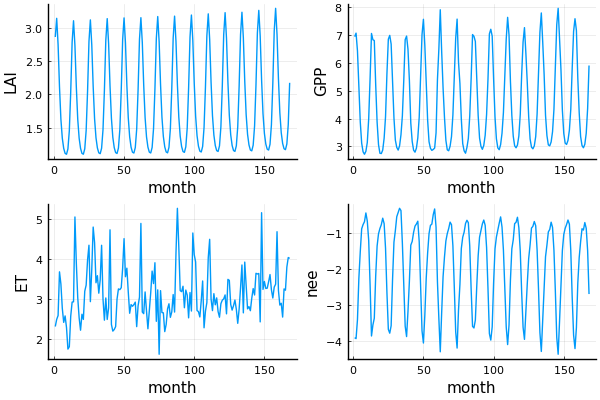

In [7]:
lai_plot = plot(sol[1, 2:dalec.NODAYS+1], ylabel=dalec_vars[1], xlabel="month", label=nothing)
gpp_plot = plot(sol[2, 2:dalec.NODAYS+1], ylabel=dalec_vars[2], xlabel="month", label=nothing)
et_plot = plot(sol[3, 2:dalec.NODAYS+1], ylabel=dalec_vars[3], xlabel="month", label=nothing)
nee_plot = plot(sol[32, 2:dalec.NODAYS+1], ylabel=dalec_vars[32], xlabel="month", label=nothing)
plot(lai_plot, gpp_plot, et_plot, nee_plot)